## Đồ án 3: Linear regression <a class="anchor" id="c2"></a>

### Nội dung đồ án <a class="anchor" id="c21"></a>

File **"wine.csv"** là cơ sở dữ liệu đánh giá chất lượng của 1200 chai rượu vang theo thang điểm 1 - 10 dựa trên 11 tính chất khác nhau. 

Xây dựng mô hình đánh giá chất lượng rượu sử dụng phương pháp hồi quy tuyến tính.

	a. Sử dụng toàn bộ 11 đặc trưng đề bài cung cấp.
    
	b. Sử dụng duy nhất 1 đặc trưng cho kết quả tốt nhất. (Gợi ý: Phương pháp Cross Validation)
    
	c. Xây dựng một mô hình của riêng bạn cho kết quả tốt nhất.

In [1]:
random_state = 42
import numpy as np
import random
np.random.seed(random_state)
random.seed(random_state)
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Đọc đường dẫn ảnh từ google drive
path_data ='wine.csv'

In [3]:
import pandas as pd
df = pd.read_csv(path_data, sep=';')
print(df.head())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]


In [4]:
# Hiển thị 1 số thông tin về dữ liệu
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,8.625271,0.519133,0.293353,2.564470,0.089266,15.242702,46.884070,0.997059,3.298582,0.665738,10.383069,5.664721
std,1.781795,0.179208,0.196751,1.264441,0.048310,10.210406,33.949177,0.001878,0.156161,0.175921,1.091891,0.809593
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.300000,0.390000,0.120000,1.900000,0.071000,7.000000,21.000000,0.996000,3.195000,0.560000,9.500000,5.000000
50%,8.300000,0.500000,0.290000,2.200000,0.080000,13.000000,38.000000,0.997020,3.300000,0.620000,10.000000,6.000000
75%,9.600000,0.630000,0.450000,2.700000,0.092000,21.000000,63.000000,0.998175,3.390000,0.735000,11.000000,6.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003200,3.900000,2.000000,14.900000,8.000000


In [5]:
# Hiển thị thông tin thuộc tính từng cột dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1199 non-null   float64
 1   volatile acidity      1199 non-null   float64
 2   citric acid           1199 non-null   float64
 3   residual sugar        1199 non-null   float64
 4   chlorides             1199 non-null   float64
 5   free sulfur dioxide   1199 non-null   float64
 6   total sulfur dioxide  1199 non-null   int64  
 7   density               1199 non-null   float64
 8   pH                    1199 non-null   float64
 9   sulphates             1199 non-null   float64
 10  alcohol               1199 non-null   float64
 11  quality               1199 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 112.5 KB


In [6]:
# Đếm số lượng giá trị ở cột quality
df['quality'].value_counts()

5    513
6    463
7    170
4     35
8     13
3      5
Name: quality, dtype: int64

In [7]:
# Đọc thông tin dữ liệu. Lấy 11 thuộc tính làm dữ liệu train, cột cuối cùng là nhãn dự đoán

X_data = df.iloc[:,:-1].values
y_data = df.iloc[:,-1].values
bias = np.ones(X_data.shape[0])
bias = np.resize(bias, (1, X_data.shape[0]))
X_data = np.concatenate((X_data, bias.T), axis=1)


In [8]:
# Hiển thị ví dụ
for index,item in enumerate(X_data[0:5]):
    print("X: " +  str(item))
    print("y: " + str(y_data[index]))
    print(len(item))

X: [ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4     1.    ]
y: 5
12
X: [ 7.8     0.88    0.      2.6     0.098  25.     67.      0.9968  3.2
  0.68    9.8     1.    ]
y: 5
12
X: [7.80e+00 7.60e-01 4.00e-02 2.30e+00 9.20e-02 1.50e+01 5.40e+01 9.97e-01
 3.26e+00 6.50e-01 9.80e+00 1.00e+00]
y: 5
12
X: [11.2    0.28   0.56   1.9    0.075 17.    60.     0.998  3.16   0.58
  9.8    1.   ]
y: 6
12
X: [ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4     1.    ]
y: 5
12


In [9]:
# Hàm chuẩn hóa dữ liệu
def scale_data(X_data):
    X_data = X_data-np.mean(X_data, axis=0)
    sd = np.std(X_data, axis=0)
    return X_data/sd
#X_data = scale_data(X_data)

In [10]:
#Chia dữ liệu thành 2 tập train, và test
def shuffle_split_data(X, y, split_rate = 80):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, split_rate)
    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = shuffle_split_data(X_data, y_data)
print("Số lượng dữ liệu là:")
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

Số lượng dữ liệu là:
959 959
240 240


In [11]:
# Hàm dự đoán kết quả
def predict(theta,input):
    predict_value = np.dot(input, theta)
    return predict_value

In [12]:
# Ta có thể thay giá trị vòng lặp thì sẽ ra các giá trị khác nhau. nên thử nghiệm các giá trị khác nhau để biết
def linear_regression(X_train,y_train):
    theta = np.linalg.pinv(X_train) @ y_train
    return theta

# Câu a: Sử dụng 11 đặc trưng để tính giá trị theta
theta = linear_regression(X_train,y_train)
print("theta : ", theta)
print(len(theta))

theta :  [ 4.87759274e-02 -1.14735125e+00 -2.75214334e-01  2.50632876e-02
 -1.38956054e+00  4.05905768e-03 -4.11906162e-03 -3.16416918e+01
 -2.55430940e-01  7.17838134e-01  2.70607728e-01  3.52083902e+01]
12


In [13]:
y_pred = []
for index in range(len(y_test)):
    y_pred.append(predict(theta,X_test[index]))
def calculate_score(y_test,y_pred):
    sum_error = 0.0
    for index in range(len(y_pred)):
        #print('Giá trị đúng: ',y_test[index],' : Giá trị dự đoán ',y_pred[index])
        sum_error += np.mean(abs(y_test[index] - y_pred[index]))
    error = sum_error/len(y_pred)
    return error
error = calculate_score(y_test,y_pred)

In [14]:
print("Độ lỗi : ", error)

Độ lỗi :  0.488231491706842


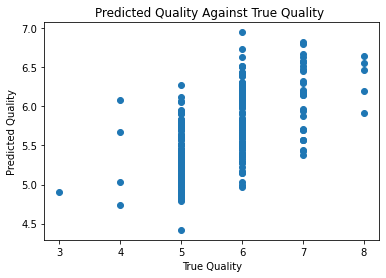

In [15]:
import matplotlib.pylab as plt
y_pred = []
for index in range(len(y_test)):
    y_pred.append(predict(theta,X_test[index]))
plt.scatter(y_test, y_pred)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted Quality Against True Quality ')
plt.show()

In [16]:
# Đây là đoạn code sử dụng pp Cross Validation trên từng đặc trưng 1. Giá trị trung bình là giá trị cuối cùng. K ở đây chọn là 5.
from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
from math import sqrt

n_split = 5
kf = KFold(n_splits=n_split)

list_output = []
list_name = []
for index,name in enumerate(df.columns[:-1]):
    print("Đặc trưng: ", name)
    list_name.append(name)
    X_data = np.array(df[name])
    X_data = X_data.reshape((X_data.shape[0], 1))
    bias = X_data[:, X_data.shape[1]-1].reshape((X_data.shape[0], 1))
    X_data = np.concatenate((X_data, bias), axis=1)

    sum_mae = 0.0
    for train_index, test_index in kf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        
        theta = linear_regression(X_train,y_train)
        y_pred = []
        for id in range(len(y_test)):
            y_pred.append(predict(theta,X_test[id]))
        y_test = [item for item in y_test]
      
        mae = calculate_score(y_test,y_pred)
        sum_mae += mae

    print("Average MSE: ",sum_mae/n_split)
    list_output.append(sum_mae/n_split)
    print("-----------------------------------------------------------")
print(list_output)
print("Đặc trưng có gia trị tốt nhất là : ", list_name[list_output.index(min(list_output))])
print("Độ đo thấp nhất là : ", min(list_output))

Đặc trưng:  fixed acidity
Average MSE:  1.0686682302438957
-----------------------------------------------------------
Đặc trưng:  volatile acidity
Average MSE:  1.8352253038668593
-----------------------------------------------------------
Đặc trưng:  citric acid
Average MSE:  2.605166745674363
-----------------------------------------------------------
Đặc trưng:  residual sugar
Average MSE:  2.0192410577484696
-----------------------------------------------------------
Đặc trưng:  chlorides
Average MSE:  2.0888991309672305
-----------------------------------------------------------
Đặc trưng:  free sulfur dioxide
Average MSE:  2.8435722742148086
-----------------------------------------------------------
Đặc trưng:  total sulfur dioxide
Average MSE:  3.1418468444880765
-----------------------------------------------------------
Đặc trưng:  density
Average MSE:  0.7044857110838194
-----------------------------------------------------------
Đặc trưng:  pH
Average MSE:  0.7269925651942

In [17]:
# Question 3
# Lựa chọn các đặc trưng sau đây làm mô hình. Dựa vào mô hình trên ta chọn 6 đặc trưng có độ lỗi thấp nhất chạy thử.
# Tự thay thế thí nghiệm lựa chọn cho cái nào phù hợp. Thêm bớt thì chỗ features thì tuỳ.
features = ["volatile acidity","chlorides","residual sugar","fixed acidity","density","pH","alcohol","quality"]


df_feature = pd.DataFrame(df, columns=features)
X_data2 = df_feature.iloc[:,:-1].values
y_data2 = df_feature.iloc[:,-1].values

bias2 = np.ones(X_data2.shape[0])
bias2 = np.resize(bias2, (1, X_data2.shape[0]))
X_data2 = np.concatenate((X_data2, bias2.T), axis=1)


X_train2, y_train2, X_test2, y_test2 = shuffle_split_data(X_data2, y_data2)
print("Số lượng dữ liệu là:")
print(len(X_train2),len(y_train2))
print(len(X_test2),len(y_test2))
print(X_train2[0])

Số lượng dữ liệu là:
959 959
240 240
[0.7    0.076  1.9    7.4    0.9978 3.51   9.4    1.    ]


In [18]:
# Huấn luyện mô hình
theta2 = linear_regression(X_train2,y_train2)
print(theta2)
# Dự đoán trên tập test
y_pred2 = []
for id in range(len(y_test2)):
    y_pred2.append(predict(theta2,X_test2[id]))
y_test2 = [item for item in y_test2]

mse2 = calculate_score(y_test2,y_pred2)
print("error: ",mse2)

[-1.07225035e+00 -5.84361319e-01  6.77647278e-03  3.60181215e-02
 -8.07829007e+00 -3.06464242e-01  3.53262903e-01  1.13461380e+01]
error:  0.5583622074409094
